In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline 

from scipy.special import gamma

In [2]:
def ft_phase_screen(D=2, r0=0.1, N=2048, delta=0.0025, L0=1000, l0=0.001):
    delta_f = 1/(N*delta) # delta is the sampling interval (periodicity), delta_f is the wavenumber increment
    f_x = np.arange(-np.floor(N/2), np.floor(N/2)) * delta_f
    f_x, f_y = np.meshgrid(f_x, -f_x)
    
    def cart2pol(x, y):
        f = np.sqrt(x**2 + y**2)
        th = np.arctan2(y, x)
        return th, f
    
    th, f = cart2pol(f_x, f_y)
    f_m = 5.92/l0/(2*np.pi)
    f_0 = 1/L0
    
    nae = 22/6.0 #Normalized alpha value
    Bnume = gamma(nae/2.0)
    Bdenome = 2.0**(2.0-nae)*np.pi*nae*gamma(-nae/2.0)
    conee = (2.0* (8.0/(nae-2.0) *gamma(2.0/(nae-2.0)))**((nae-2.0)/2.0))
    Bface = (2.0*np.pi)**(2.0-nae) * (Bnume/Bdenome)
    ae = gamma(nae-1.0)*np.cos(nae*np.pi/2.0)/(4.0*np.pi**2.0)
    c_ae = (gamma(0.5*(5.0-nae))*ae*2.0*np.pi/3.0)**(1.0/(nae-5.0))
    fme = c_ae/l0   # Inner scale frequency(1/m)
    f_m = fme
    
    #Power Spectral Density of 
    # phase power spectral density for the Kolmogorov refractive index power spectral density 
    PSD_phi = 0.023 * r0 ** (-5/3) * np.exp(-(f/f_m)**2) / ((f**2 + f_0**2) ** (11/6))
    PSD_phi[int(N/2),int(N/2)] = 0
    
    
    #  ... an NxN field of pseudorandom complex numbers is multiplied by sqrt of the Power Spectral Density (PSD)
    # divided by the wavenumber increment (delta) and inverse transformed by 2-D discrete Fourier Transform (DFT)
    # to yield the desired random phase field 
    #im = np.random.normal(size=(N, N))
    #re = np.random.normal(size=(N, N))
    #cn = (1j*im + re) * np.sqrt(PSD_phi) * delta_f 
    cn = (np.random.randn(N, N) + 1j*np.random.randn(N, N) )
    cn = cn * np.sqrt(PSD_phi)*delta_f
    
    def ift2(G, delta_f):
        N, N = G.shape
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(G))) * (N * delta_f)**2
    
    #phz = np.real(ift2(cn, 1))
    
    phz_temp  = np.fft.ifft2(np.fft.fftshift(cn))*((N)**2)
    phz1 = np.real(phz_temp)
    
    return phz1 # returns phase screen with variations in radians

In [3]:
D=2
r0=0.1
N=2048
delta=0.0025
L0=10
l0=0.005

In [142]:
realizations = []
#realizations = {}
for i in range(20):
    realization = ft_phase_screen(D=2, r0=r0, N=N, delta=delta, L0=L0, l0=l0)
    realizations.extend(realization.reshape([1, realization.size])[0])
    #realizations[i] = pd.Series(realization.reshape([1, realization.size])[0])

In [138]:
realizations = pd.Series(realizations)

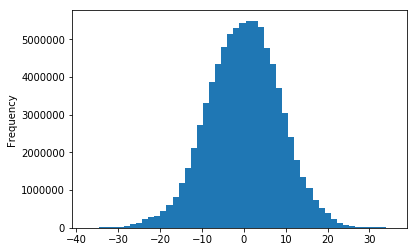

In [144]:
#sm = realizations.min()
#lg = realization.max()
#print(sm, lg, lg-sm)
#bins = np.ceil(lg-sm)
#realizations.plot(kind='hist', bins=bins)
pd.Series(realizations).plot(kind='hist', bins=50)

In [ ]:
#Charnotskii/Bos generalized phase consistency parameter
na = (11/3.)
Bnum = gamma(na/2.0)
Bdenom = 2.0**(2.0-na)*np.pi*na*gamma(-na/2.0)
Bfac = (2.0*np.pi)**(2.0-na) * (Bnum/Bdenom)

#c1 Striblings Consistency parameter. Evaluates to 6.88 in Kolmogorov turb.
cone = (2.0* (8.0/(na-2.0) *gamma(2.0/(na-2.0)))**((na-2.0)/2.0))
cone * Bfac

In [61]:
# Set up parameters for Kolmogorov PSD
nae = 22/6.0 #Normalized alpha value
Bnume = gamma(nae/2.0)
Bdenome = 2.0**(2.0-nae)*np.pi*nae*gamma(-nae/2.0)
conee = (2.0* (8.0/(nae-2.0) *gamma(2.0/(nae-2.0)))**((nae-2.0)/2.0))
Bface = (2.0*np.pi)**(2.0-nae) * (Bnume/Bdenome)
ae = gamma(nae-1.0)*np.cos(nae*np.pi/2.0)/(4.0*np.pi**2.0)
c_ae = (gamma(0.5*(5.0-nae))*ae*2.0*np.pi/3.0)**(1.0/(nae-5.0))
fme = c_ae/l0   # Inner scale frequency(1/m)      

print(fme)

1181.8299964138398


In [63]:
5.92/l0/(2*np.pi)

188.43945262080408

In [5]:
                      # Geometry
D2 = 0.5              # Diameter of observation aperture [m]
wvl = 1e-6            # Optical wavelenght [m]
k = 2 * np.pi / wvl   # wavenumber [rad/m]
propDist = 10e3       # propagation distance [m]

In [6]:
def SplitStepProp(Uin, phaseScreenStack):
    
    #phaseScreenStack = np.exp(1j*phaseScreenStack)
    
    N, N = Uin.shape
    nx = np.arange(-np.floor(N/2), np.floor(N/2))
    nx, ny = np.meshgrid(nx, nx)
    k = 2 * np.pi / wvl
    
    r1 = np.sqrt(nx**2 + ny**2) # radius
    
    # Super Gaussian absorbing boundary
    def MakeSGB(sigma=0.55):
        rad = np.sqrt(nx**2 + ny**2) # radius
        w = sigma*N 
        sg = np.exp(-(( rad / w)**16)) # Flatte et al use a SG with n=8
        
        return sg
    
    sg = MakeSGB(sigma=0.45)
    
    # Propagation Geometry   
    numScr = phaseScreenStack.shape[2]
    
    dzProps = np.ones(numScr + 2) * (propDist / numScr)
    #dzProps[0:2] = 1.0 * (propDist / numScr)
    #dzProps[numScr:numScr+2] = 1.0 * (propDist / numScr)
    dzProps[0:2] = 0.5 * (propDist / numScr)
    dzProps[numScr:numScr+2] = 0.5 * (propDist / numScr)

    propLocs = np.zeros(numScr + 3)

    for zval in range(0, numScr+2):
        propLocs[zval+1] = propLocs[zval] + dzProps[zval]

    fracPropDist = propLocs/propDist

    propSampling = (Rdx - dx) * fracPropDist + dx
    samplingRatio = propSampling[1:len(propSampling)] / propSampling[0:len(propSampling)-1]
    
    P0 = np.exp(1j * (k/ (2*dzProps[0]) ) * (r1**2) * (1-samplingRatio[0]) )
    
    plane = np.ones([N, N])
    source = plane
    
    # Initial propagation
    Uin = P0 * source * np.exp(1j * phaseScreenStack[:,:,0])
    
    for pcount in range(1,len(propLocs)-2):
        UinSpec = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Uin)))  

        #Set spatial frequencies at propagation plane
        delta_f = 1/(N * propSampling[pcount])
        f_x = nx * delta_f
        f_y = ny * delta_f
        fsq = f_x*2 + f_y**2
    
        #Quadratic Phase Factor
        quadPhaseFac = np.exp( -1j * np.pi * wvl * dzProps[pcount] * samplingRatio[pcount] * fsq)
        #quadPhaseFac = 1
        
        Uin = np.fft.ifftshift(np.fft.ifft2( np.fft.ifftshift(UinSpec * quadPhaseFac)) ) 
            
        Uin = Uin * sg * np.exp(1j * phaseScreenStack[:,:,pcount-1])
        
    x = np.linspace(-N/2, N/2-1, N) * Rdx
    y = x
    xR, yR = np.meshgrid(x, y)
    rR = np.sqrt(xR**2 + yR**2)
        
    PF = np.exp(1j* ( k/ (2*dzProps[-1]) ) * (rR**2) * (samplingRatio[-1]))
    
    Uout = PF * Uin
    return Uout

In [7]:
numScr = 10
plane = np.ones([N, N])

dx = 5e-3             # Sampling interval at source
Rdx = dx              # Sampling interval at receiver

phz = np.zeros(shape=(N, N, numScr))
#phz_lo = np.zeros(shape=(N, N, NumScr))
phz_hi = np.zeros(shape=(N, N, numScr))


for idxscr in range(0,numScr):
    phz_hi[:,:,idxscr] = ft_phase_screen(D=2, r0=0.1, N=N, delta=delta, L0=L0, l0=l0)
    phz[:,:,idxscr] = phz_hi[:,:,idxscr]

phaseScreenStack = phz #np.exp(1j*phz)
res = SplitStepProp(plane, phaseScreenStack)

In [8]:
intensity = np.sqrt(np.conjugate(res) * res).real
nominator = pd.DataFrame(intensity**2).mean().mean()
print(nominator)
denominator = pd.DataFrame(intensity).mean().mean()**2
print(denominator)
variance = nominator/denominator-1
print('intensity variance:', variance)

0.41232675372232724
0.16315031952285783
intensity variance: 1.5272813128910796


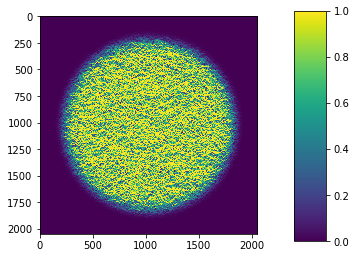

In [12]:
plt.imshow(intensity).set_clim(0.0, 1)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

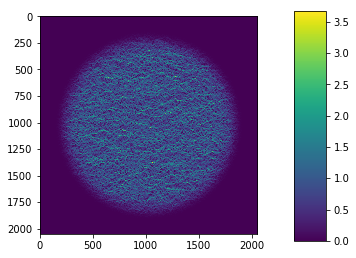

In [10]:
plt.imshow(intensity)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [19]:
np.log(0.6)

-0.5108256237659907

In [22]:
((2*np.pi)/0.532e-6)**(7/6)

178229508.2076271

In [23]:
(10e3)**(11/6)

21544346.900318824

In [24]:
0.2/(0.312*(((2*np.pi)/0.532e-6)**(7/6))*((10e3)**(11/6)))

1.6694078816499612e-16

In [25]:
(0.423*(((2*np.pi)/0.532e-6)**(2))*(1.6694078816499612e-16)*(10e3))**(-3/5)

0.06367023027268884